In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from stellargraph import StellarGraph
from stellargraph.datasets import Cora, CiteSeer, PubMedDiabetes

import matplotlib.pyplot as plt

from scipy import linalg
from scipy.spatial.distance import pdist, squareform
import scipy.sparse as sp

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

from IPython.display import display, HTML

In [2]:
class CitationNetworkVisualizer:
    def __init__(self, dataset_name):
        self.dataset_name = dataset_name
        self.graph = None
        self.node_subjects = None
        self.node_features = None

    def load_data(self):
        """Load the specified citation dataset and prepare data for spectral clustering."""
        if self.dataset_name == 'cora':
            dataset = Cora()
        elif self.dataset_name == 'citeseer':
            dataset = CiteSeer()
        elif self.dataset_name == 'pubmed':
            dataset = PubMedDiabetes()
        else:
            raise ValueError("Unsupported dataset name. Choose 'cora', 'citeseer', or 'pubmed'.")
        
        display(HTML(dataset.description))
        self.graph, self.node_subjects = dataset.load()

        # Convert the graph to a dense PyTorch tensor
        adjacency_matrix = self.graph.to_adjacency_matrix(weighted=False)

        # Prepare labels
        labels = self.node_subjects.values

        feature_matrix = self.graph.node_features()

        return feature_matrix, adjacency_matrix, labels

    def visualize(self):
        """Visualize the citation dataset network."""
        # Convert to NetworkX graph for visualization
        G_nx = self.graph.to_networkx()

        # Create a network layout
        pos = nx.spring_layout(G_nx)

        # Create a color map based on the labels
        unique_labels = np.unique(self.node_subjects)
        color_map = {label: i for i, label in enumerate(unique_labels)}
        colors = [color_map[label] for label in self.node_subjects]

        # Draw nodes and edges
        plt.figure(figsize=(12, 12))
        nx.draw_networkx_nodes(G_nx, pos, node_size=50, node_color=colors, cmap=plt.get_cmap('Set1'), alpha=0.6)
        nx.draw_networkx_edges(G_nx, pos, alpha=0.3)
        
        # Create a legend
        handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                               markerfacecolor=plt.get_cmap('Set1')(color_map[label]), markersize=10) 
                   for label in unique_labels]
        plt.legend(handles=handles, title="Classes")
        
        plt.title(f"{self.dataset_name.capitalize()} Dataset Citation Network")
        plt.axis('off')
        plt.show()

In [3]:
# Load PubMedDiabetes dataset
dataset_name = 'citeseer'
citation_visualizer = CitationNetworkVisualizer(dataset_name)
feature_matrix, data, labels = citation_visualizer.load_data()
unique_labels = set(labels)

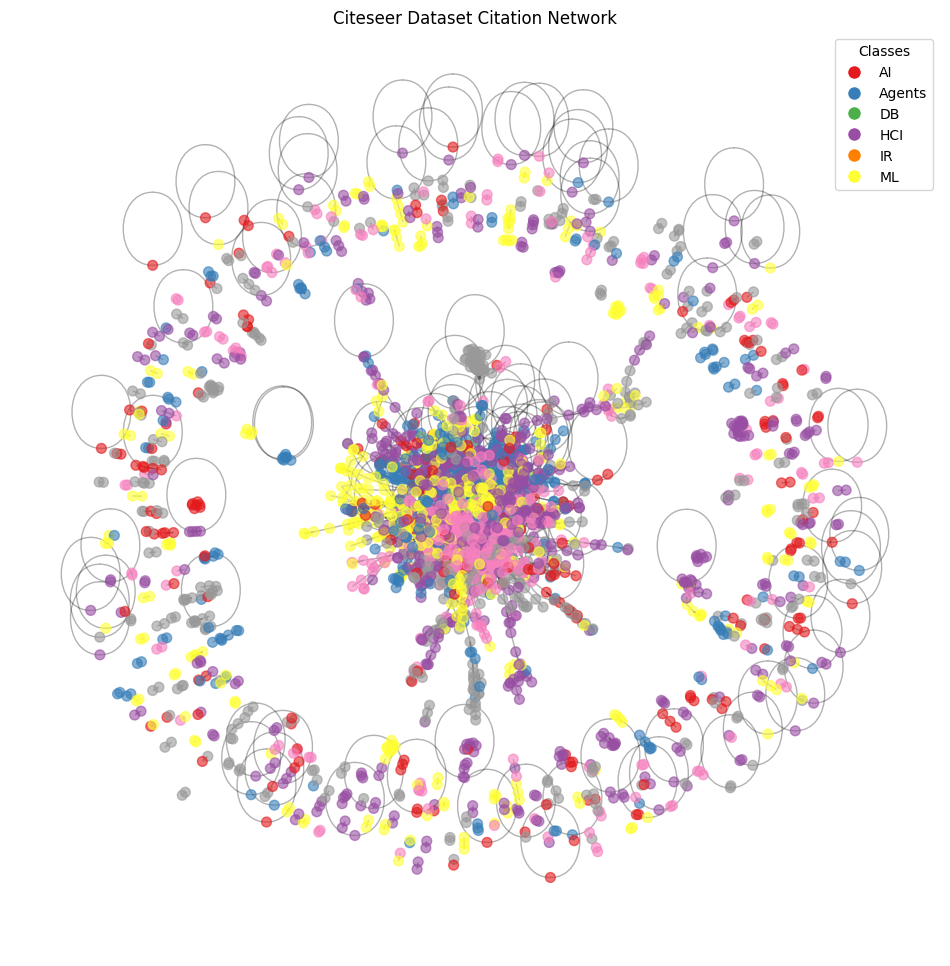

In [4]:
citation_visualizer.visualize()

In [5]:
unique_labels

{'AI', 'Agents', 'DB', 'HCI', 'IR', 'ML'}

In [6]:
def preprocess_data(adjacency_matrix, labels, feature_matrix):
    # Ensure adjacency matrix is sparse
    adjacency_matrix = sp.csr_matrix(adjacency_matrix)
    
    # Remove diagonal elements (self-loops)
    adjacency_matrix.setdiag(0)
    adjacency_matrix.eliminate_zeros()  # Remove explicit zeros
    
    # Calculate degree matrix (as a vector)
    degree_vector = np.array(adjacency_matrix.sum(axis=1)).flatten()
    
    # Identify isolated nodes (degree == 0)
    isolated_nodes = np.where(degree_vector == 0)[0]
    non_isolated_mask = np.isin(np.arange(adjacency_matrix.shape[0]), isolated_nodes, invert=True)

    # Filter adjacency matrix and labels for non-isolated nodes
    adjacency_matrix_non_isolated = adjacency_matrix[non_isolated_mask][:, non_isolated_mask]
    labels_non_isolated = labels[non_isolated_mask]
    feature_matrix_non_isolated = feature_matrix[non_isolated_mask, :]

    # Encode labels
    label_encoder = LabelEncoder()
    encoded_labels_non_isolated = label_encoder.fit_transform(labels_non_isolated)

    return adjacency_matrix_non_isolated, encoded_labels_non_isolated, feature_matrix_non_isolated

In [7]:
def save_to_csv(adjacency_matrix, labels, feature_matrix, nodes_file="nodes.csv", edges_file="edges.csv"):
    """Save the node and edge data into separate CSV files."""
    
    # Save node information (ID, features, labels) to CSV
    node_data = pd.DataFrame({
        'id': np.arange(feature_matrix.shape[0]),
        'features': [list(f) for f in feature_matrix],  # convert features to list
        'label': labels
    })
    node_data.to_csv(nodes_file, index=False)

    # Save adjacency matrix (edge list) to CSV
    edges = np.argwhere(adjacency_matrix > 0)  # get index of non-zero entries (edges)
    edge_list = pd.DataFrame(edges, columns=['source_id', 'target_id'])
    edge_list.to_csv(edges_file, index=False)

    print(f"Nodes saved to {nodes_file} and edges saved to {edges_file}.")

In [8]:
def spectral_clustering(adjacency_matrix, labels, laplacian, number_of_clusters):
    
    degree_vector = np.array(adjacency_matrix.sum(axis=1)).flatten()

    if laplacian == "sym":

        # Normalized Symmetric laplacian matrix
        d_half = sp.diags(1.0 / np.sqrt(degree_vector))
        laplacian_matrix_normalized = d_half @ adjacency_matrix @ d_half
        
    if laplacian == "rw":

        # Normalized Random Walk laplacian matrix
        d_inverse = sp.diags(1.0 / degree_vector)
        laplacian_matrix_normalized = d_inverse @ adjacency_matrix

    if laplacian == "ad":
        
        # Adaptive Laplacian matrix
        D_local = np.zeros_like(degree_vector)
        
        for i in range(len(degree_vector)):
            neighbors = adjacency_matrix[i].nonzero()[1]
            if len(neighbors) > 0:
                D_local[i] = adjacency_matrix[neighbors].sum() / degree_vector[i]
            else:
                D_local[i] = 0
        
        D_local_inv = sp.diags(1.0 / np.sqrt(D_local))
        laplacian_matrix_normalized = D_local_inv @ adjacency_matrix @ D_local_inv

    laplacian_matrix_normalized_densed = laplacian_matrix_normalized.toarray()

    if check_symmetric(laplacian_matrix_normalized_densed) :
        # Calculating eigenvalues and eigenvectors for symmetric matrix
        e, v = np.linalg.eigh(laplacian_matrix_normalized_densed)
    else:
        # Calculating eigenvalues and eigenvectors for non-symmetric matrix
        e, v = np.linalg.eig(laplacian_matrix_normalized_densed)
        idx = np.argsort(np.real(e))
        e = np.real(e[idx])
        v = np.real(v[:, idx]) 
    
    # Calculate eigengap
    eigengap = np.diff(e)
    optimal_number_of_clusters = np.argmax(eigengap[:10]) + 1   
    
    # Use the user-defined k, 2k, and eigengap for clustering
    k_values = [number_of_clusters, 2*number_of_clusters, optimal_number_of_clusters]

    results = []

    for i, current_k in enumerate(k_values):
        if i == 0:
            # First case: k
            X = v[:, -number_of_clusters:]
            n_clusters = number_of_clusters
        elif i == 1:
            # Second case: 2k
            X = v[:, -(2*number_of_clusters):]
            n_clusters = number_of_clusters
        else:
            # Third case: optimal number of clusters from eigengap
            X = v[:, -optimal_number_of_clusters:]
            n_clusters = optimal_number_of_clusters
    
        # KMeans clustering
        clustering = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = clustering.fit_predict(X)
        
        sil_score = silhouette_coefficient(adjacency_matrix.toarray(), cluster_labels)[3]
        ar_score = adjusted_rand_score(labels, cluster_labels)
        am_score =  adjusted_mutual_info_score(labels, cluster_labels)

        results.append((sil_score, ar_score, am_score, current_k,cluster_labels))

    return results

In [9]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [10]:
def euclidean_distance(point1, point2):
    """Calculate the Euclidean distance between two points."""
    return np.linalg.norm(point1 - point2)

def calculate_cohesion(point, cluster_points):
    """Calculate the cohesion of a point within its cluster."""
    if len(cluster_points) == 0:
        return 0.0
    distances = [euclidean_distance(point, other_point) for other_point in cluster_points]
    return np.mean(distances)

def calculate_separation(point, other_clusters):
    """Calculate the separation of a point from other clusters."""
    if len(other_clusters) == 0:
        return 0.0
    min_distances = [
        np.min([euclidean_distance(point, other_point) for other_point in cluster_points]) 
        for cluster_points in other_clusters
    ]
    return np.mean(min_distances)

def silhouette_coefficient(data, labels):
    """Calculate the silhouette coefficients for a given dataset and cluster labels."""
    num_points = data.shape[0]
    all_cohesion = []
    all_separation = []
    all_silhouette = []

    for i in range(num_points):
        point = data[i]
        cluster_index = labels[i]
        cluster_points = data[labels == cluster_index]  # Points in the same cluster

        a = calculate_cohesion(point, cluster_points)
        all_cohesion.append(a)

        other_clusters = [data[labels == idx] for idx in set(labels) if idx != cluster_index]
        b = calculate_separation(point, other_clusters)
        all_separation.append(b)

        silhouette_value = (b - a) / max(a, b) if max(a, b) != 0 else 0.0
        all_silhouette.append(silhouette_value)

    avg_silhouette = np.mean(all_silhouette)

    return all_cohesion, all_separation, all_silhouette, avg_silhouette

In [11]:
laplacian_methods = ["sym", "rw","ad"]
silhouette_scores = []
adjusted_rand_scores = []
adjusted_mutual_info_scores = []
clusters = []
laplacian = []
cluster_labels = []

adjacency_matrix_non_isolated, labels_non_isolated, feature_matrix_non_isolated = preprocess_data(data, labels, feature_matrix)

save_to_csv(adjacency_matrix_non_isolated, labels_non_isolated, feature_matrix_non_isolated)

/Users/evi/.pyenv/versions/3.8.14/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Nodes saved to nodes.csv and edges saved to edges.csv.


In [12]:
for laplace in laplacian_methods:
    metrics = spectral_clustering(adjacency_matrix_non_isolated, labels_non_isolated, laplace, 6)
    
    for si, ar, am, cl,l in metrics:
        laplacian.append(laplace)
        
        silhouette_scores.append(si)
        adjusted_rand_scores.append(ar)
        clusters.append(cl)
        cluster_labels.append(l)
        adjusted_mutual_info_scores.append(am)

/Users/evi/.pyenv/versions/3.8.14/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/evi/.pyenv/versions/3.8.14/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/evi/.pyenv/versions/3.8.14/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/evi/.pyenv/versions/3.8.14/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The defa

In [13]:
experiment_citeseer = pd.DataFrame(list(zip(laplacian,silhouette_scores,adjusted_rand_scores,adjusted_mutual_info_scores,clusters)), 
             columns= ["laplacian", "silhouette", "adjusted_rand","adjusted_mutual_info","clusters"])

experiment_citeseer

,laplacian,silhouette,adjusted_rand,adjusted_mutual_info,clusters
0,sym,-0.180927,0.000770,0.005458,6
1,sym,-0.181766,0.001294,0.003074,12
2,sym,-1.000000,0.000000,0.000000,1
3,rw,-0.176279,0.005898,0.011053,6
4,rw,-0.177606,0.004745,0.006975,12
5,rw,-1.000000,0.000000,0.000000,1
6,ad,0.126887,-0.000023,0.001877,6
7,ad,0.126887,0.000304,0.002493,12
8,ad,0.127545,0.000207,0.003127,8


In [14]:
# Finding the best results for each metric and their indices
best_silhouette_index = experiment_citeseer['silhouette'].idxmax()
best_adjusted_rand_index = experiment_citeseer['adjusted_rand'].idxmax()
adjusted_mutual_info_index = experiment_citeseer['adjusted_mutual_info'].idxmax()

best_silhouette = experiment_citeseer.loc[best_silhouette_index]
best_adjusted_rand = experiment_citeseer.loc[best_adjusted_rand_index]
best_adjusted_mutual_info = experiment_citeseer.loc[adjusted_mutual_info_index]

# Create a clearer DataFrame with the best results and their indices
best_results = pd.DataFrame({
    'Metric': ['Best Silhouette', 'Best Adjusted Rand', 'Best Adjusted Mutual Info'],
    'Index': [
        best_silhouette_index,
        best_adjusted_rand_index,
        adjusted_mutual_info_index
    ],
    'Laplacian': [
        best_silhouette['laplacian'],
        best_adjusted_rand['laplacian'],
        best_adjusted_mutual_info['laplacian']
    ],
    'Silhouette Score': [
        best_silhouette['silhouette'],
        None,  # Placeholder for clarity
        None   # Placeholder for clarity
    ],
    'Adjusted Rand Index': [
        None,  # Placeholder for clarity
        best_adjusted_rand['adjusted_rand'],
        None   # Placeholder for clarity
    ],
    'Adjusted Mutual Info': [
        None,  # Placeholder for clarity
        None,  # Placeholder for clarity
        best_adjusted_mutual_info['adjusted_mutual_info']
    ],
    'Clusters': [
        best_silhouette['clusters'],
        best_adjusted_rand['clusters'],
        best_adjusted_mutual_info['clusters']
    ]
})

# Display the best results
best_results

,Metric,Index,Laplacian,Silhouette Score,Adjusted Rand Index,Adjusted Mutual Info,Clusters
0,Best Silhouette,8,ad,0.127545,NaN,NaN,8
1,Best Adjusted Rand,3,rw,NaN,0.005898,NaN,6
2,Best Adjusted Mutual Info,3,rw,NaN,NaN,0.011053,6


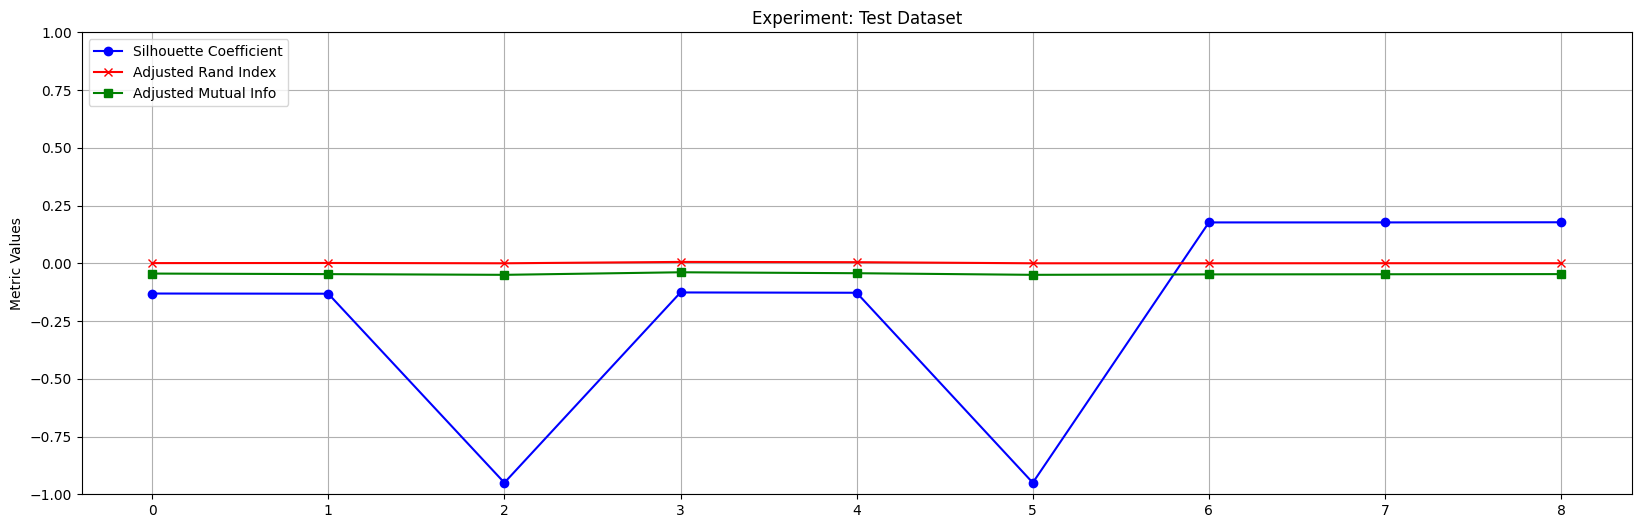

In [15]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 6))

# Define an offset to avoid overlap
offset = 0.05

# Plot silhouette coefficient with an offset
ax.plot(experiment_citeseer['silhouette'] + offset, 
        marker='o', color='b', label='Silhouette Coefficient', markersize=6)

# Plot Adjusted Rand Index with an offset
ax.plot(experiment_citeseer['adjusted_rand'], 
        marker='x', color='r', label='Adjusted Rand Index', markersize=6)

# Plot Adjusted Mutual Information with an offset
ax.plot( experiment_citeseer['adjusted_mutual_info'] - offset, 
        marker='s', color='g', label='Adjusted Mutual Info', markersize=6)

# Set labels
ax.set_ylabel('Metric Values')

# Adjust y-axis limits dynamically
ax.set_ylim(-1, 1)  # Set limits to fit the offsets

# Add a title
plt.title('Experiment: Test Dataset')

# Add a legend
ax.legend(loc='upper left')

# Show grid for better readability
plt.grid()

# Show the plot
plt.show()